# Redes neuronales
---

- **Taller 3**: Redes nueronales convolucionales.
- **Fecha de entrega**: 24 de Noviembre de 2023.
- **Enlace de entrega**: https://docs.google.com/forms/d/1IO_TKGV7snVO5krb7MDDZfdnjUTSGD9MwAvBVJc57mc/

Importamos librerías:

In [ ]:
pip install keras-tuner

In [ ]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import matplotlib.image as mpimg
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg19 import decode_predictions

<ipython-input-3-f32c2410aec4>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Cargue el conjunto de datos

Descargue el conjunto de datos de clasificación "vegetable image", disponible en: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset. Recuerde dividir su conjunto de datos en dos: Entrenamiento test.


In [ ]:
drive_root = '/content/drive/MyDrive/'
test = os.path.join(drive_root, '/content/drive/MyDrive/Vegetable Images/test')
train = os.path.join(drive_root, 'Vegetable Images/train')

In [ ]:
img_width, img_height = 224, 224
num_classes = len(os.listdir(train))
epochs = 10
batch_size = 32

# 2. Proponga una estructura neuronal

Proponga una red neuronal que le permita enfrentar el problema dado, recuerde que puede usar estrategias como él fine tuning o el trasnfer learning.

In [ ]:
# Configuración de la generación de datos
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, #normalizar pix de las imagenes
    shear_range=0.2, #gira
    zoom_range=0.2, #pues :v
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 18000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
#cargar el modelo VGG19 preentrenado sin la capa densa
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

#capas densas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#congelar
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)


Epoch 1/10
562/562 [==============================] - 4277s 8s/step - loss: 0.3122 - accuracy: 0.9268 - val_loss: 0.0334 - val_accuracy: 0.9926
Epoch 2/10
562/562 [==============================] - 315s 561ms/step - loss: 0.0234 - accuracy: 0.9949 - val_loss: 0.0198 - val_accuracy: 0.9963
Epoch 3/10
562/562 [==============================] - 307s 546ms/step - loss: 0.0127 - accuracy: 0.9973 - val_loss: 0.0200 - val_accuracy: 0.9950
Epoch 4/10
562/562 [==============================] - 321s 572ms/step - loss: 0.0098 - accuracy: 0.9978 - val_loss: 0.0149 - val_accuracy: 0.9970
Epoch 5/10
562/562 [==============================] - 310s 551ms/step - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.0137 - val_accuracy: 0.9973
Epoch 6/10
562/562 [==============================] - 310s 552ms/step - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0132 - val_accuracy: 0.9976
Epoch 7/10
562/562 [==============================] - 306s 545ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0098 - v

Muestre el resumen de su modelo

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#3. Explore los hiperparametros

Enuncie los hiperparametros necesarios a ajustar, explique por qué son importantes para su modelo y ajústelos empleando keras tuners.

**Learning Rate:** Un learning rate demasiado alto puede hacer que el modelo no converja o incluso diverja. Un learning rate demasiado bajo puede hacer que el entrenamiento sea muy lento y quedar atrapado en mínimos locales. Ajustar este parámetro de manera cuidadosa es esencial para un buen rendimiento del modelo.

**Units:** Este hiperparámetro es crucial porque determina la complejidad y capacidad del modelo para aprender patrones en los datos. Un número adecuado de unidades en las capas ocultas es esencial para lograr un equilibrio entre la capacidad de aprendizaje y la prevención del sobreajuste.


Muestre la mejor combinación de hiperparametros

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=hp.Int('units', min_value=512, max_value=2048, step=256), activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Inicializa el sintonizador
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    directory='my_tuner_dir',
    project_name='my_model_tuning')

try:
    tuner.search(train_generator, epochs=10, validation_data=test_generator)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"Best Hyperparameters: {best_hps}")
except Exception as e:
    print(f"An error occurred: {e}")


tuner.search(train_generator, epochs=10, validation_data=test_generator)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hps}")


Trial 5 Complete [00h 49m 52s]
val_accuracy: 0.9983333349227905

Best val_accuracy So Far: 0.9983333349227905
Total elapsed time: 03h 32m 59s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7d9a6c685330>
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7d9a6c685330>


In [ ]:
print("Best Hyperparameters:")
print(f"  - Units: {best_hps.get('units')}")
print(f"  - Learning Rate: {best_hps.get('learning_rate')}")


Best Hyperparameters:
  - Units: 1536
  - Learning Rate: 0.0005563202668883324


#4. Realice el entrenamiento principal
Usando los hiperparametros identificados realice el entrenamiento principal y reporte su resultado, recuerde mostrar la evidencia anecdótica en cada clase.

Muestre el resumen de su modelo

In [ ]:
# Configuración de la generación de datos
new_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

new_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

new_train_generator = new_train_datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

new_test_generator = new_test_datagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 18000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1536, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

new_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

new_model.compile(optimizer=Adam(learning_rate=0.0005563202668883324), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
new_model.fit(
    new_train_generator,
    steps_per_epoch=new_train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=new_test_generator,
    validation_steps=new_test_generator.samples // batch_size)


Epoch 1/10
562/562 [==============================] - 313s 554ms/step - loss: 0.1452 - accuracy: 0.9646 - val_loss: 0.0235 - val_accuracy: 0.9956
Epoch 2/10
562/562 [==============================] - 306s 545ms/step - loss: 0.0429 - accuracy: 0.9894 - val_loss: 0.0241 - val_accuracy: 0.9960
Epoch 3/10
562/562 [==============================] - 297s 529ms/step - loss: 0.0257 - accuracy: 0.9933 - val_loss: 0.0139 - val_accuracy: 0.9983
Epoch 4/10
562/562 [==============================] - 295s 526ms/step - loss: 0.0213 - accuracy: 0.9950 - val_loss: 0.0222 - val_accuracy: 0.9976
Epoch 5/10
562/562 [==============================] - 293s 520ms/step - loss: 0.0304 - accuracy: 0.9933 - val_loss: 0.0173 - val_accuracy: 0.9973
Epoch 6/10
562/562 [==============================] - 292s 520ms/step - loss: 0.0126 - accuracy: 0.9969 - val_loss: 0.0095 - val_accuracy: 0.9980
Epoch 7/10
562/562 [==============================] - 292s 520ms/step - loss: 0.0203 - accuracy: 0.9956 - val_loss: 0.0164 -

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
print("Precisión del primer modelo:")
first_model_accuracy = model.evaluate(test_generator)[1]
print(f"Modelo original - Precisión: {first_model_accuracy}")

print("\nPrecisión del segundo modelo:")
new_model_accuracy = new_model.evaluate(new_test_generator)[1]
print(f"Modelo modificado - Precisión: {new_model_accuracy}")


Precisión del primer modelo:
94/94 [==============================] - 16s 165ms/step - loss: 0.0187 - accuracy: 0.9973
Modelo original - Precisión: 0.9973333477973938

Precisión del segundo modelo:
94/94 [==============================] - 16s 165ms/step - loss: 0.0373 - accuracy: 0.9960
Modelo modificado - Precisión: 0.9959999918937683


1/1 [==============================] - 0s 31ms/step


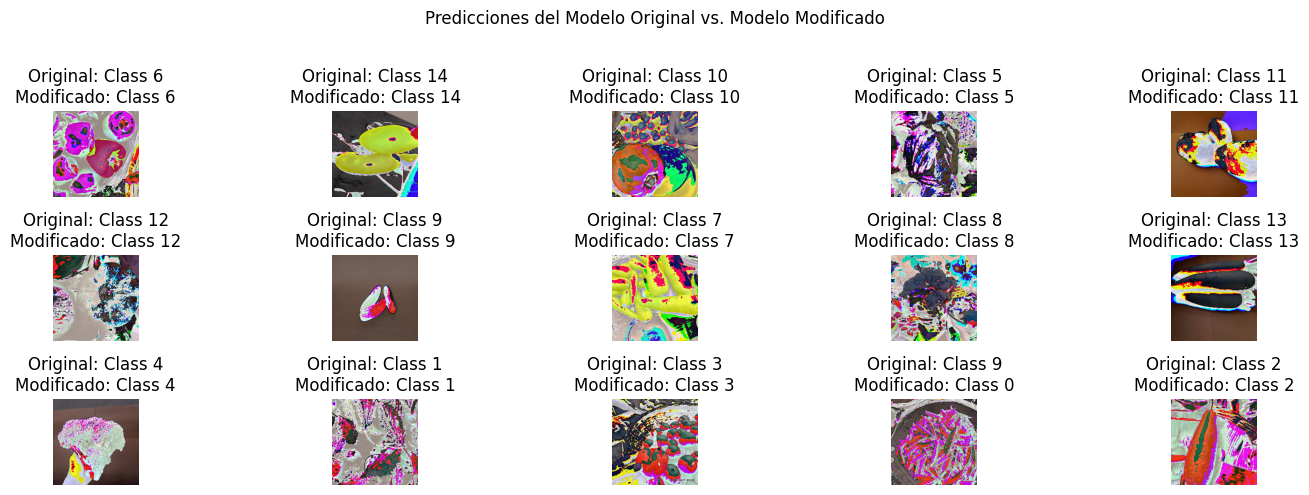

In [ ]:
def visualize_predictions(model, image_paths, title):
    num_images = len(image_paths)
    num_cols = min(num_images, 5)
    num_rows = (num_images - 1) // num_cols + 1

    plt.figure(figsize=(15, 5))
    plt.suptitle(title)

    for i, image_path in enumerate(image_paths, 1):
        img = load_and_preprocess_image(image_path)

        img = np.squeeze(img, axis=0)

        original_model_prediction = model.predict(np.expand_dims(img, axis=0))
        new_model_prediction = new_model.predict(np.expand_dims(img, axis=0))

        original_model_label = np.argmax(original_model_prediction)
        new_model_label = np.argmax(new_model_prediction)

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(np.uint8(img))
        plt.title(f'Original: Class {original_model_label}\nModificado: Class {new_model_label}')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])

visualize_predictions(model, sample_images, 'Predicciones del Modelo Original vs. Modelo Modificado')
plt.show()


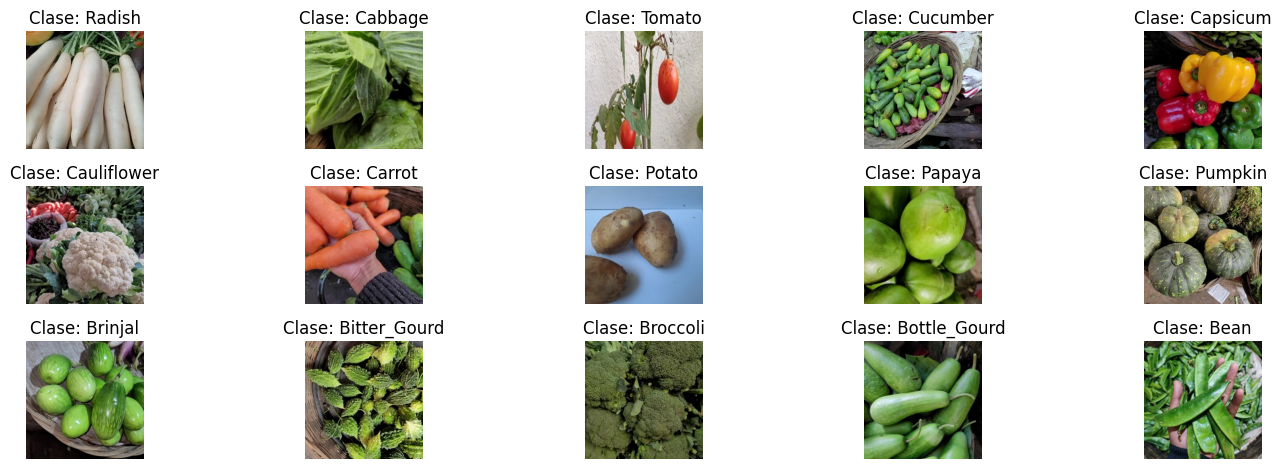

In [ ]:
def load_and_show_image(image_path, title):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

class_folders = [folder for folder in os.listdir(test) if os.path.isdir(os.path.join(test, folder))]

num_cols = 5
num_rows = (len(class_folders) - 1) // num_cols + 1

plt.figure(figsize=(15, 5))
for i, folder in enumerate(class_folders, 1):
    image_files = os.listdir(os.path.join(test, folder))
    if image_files:
        image_path = os.path.join(test, folder, image_files[0])
        title = f'Clase: {folder}'

        plt.subplot(num_rows, num_cols, i)
        load_and_show_image(image_path, title)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()